### Trying an end-to-end approach 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import os
import json
from tqdm import tqdm

### Image transformations 

In [21]:
class ResizeAndPadTransform:
    def __init__(self, target_height=128, target_width=128):
        self.target_height = target_height
        self.target_width = target_width

    def __call__(self, img):
        w, h = img.size

        # Resize based on the larger dimension:
        if w >= h:
            if w > self.target_width:
                new_w = self.target_width
                new_h = int(round(h * self.target_width / w))
                img = transforms.Resize((new_h, new_w))(img)
        else:
            if h > self.target_height:
                new_h = self.target_height
                new_w = int(round(w * self.target_height / h))
                img = transforms.Resize((new_h, new_w))(img)

        # If it’s still larger than the target, resize it (which may slightly change the aspect ratio)
        w, h = img.size
        if w > self.target_width:
            # Resize width to target_width and scale height accordingly.
            new_w = self.target_width
            new_h = int(round(h * self.target_width / w))
            img = transforms.Resize((new_h, new_w))(img)
        if h > self.target_height:
            # Resize height to target_height and scale width accordingly.
            new_h = self.target_height
            new_w = int(round(w * self.target_height / h))
            img = transforms.Resize((new_h, new_w))(img)

        # After resizing, pad if any dimension is less than 128
        w, h = img.size
        pad_w = max(0, self.target_width - w)
        pad_h = max(0, self.target_height - h)
        left = pad_w // 2
        right = pad_w - left
        top = pad_h // 2
        bottom = pad_h - top
        img = transforms.functional.pad(img, (left, top, right, bottom), fill=0)

        # Convert to tensor and normalize
        img = transforms.ToTensor()(img)
        img = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)
        
        return img

In [22]:
transform = transforms.Compose([
    ResizeAndPadTransform(target_height=128, target_width=128)
])

image_path = os.path.join("C:/Users/syeda/OneDrive/Desktop/4th Year/COSC419/jersey-number-pipeline/data/SoccerNet/train/images/0", "0_1.jpg")
image = Image.open(image_path).convert("RGB")
transformed_image = transform(image)
print(transformed_image.shape)

torch.Size([3, 128, 128])


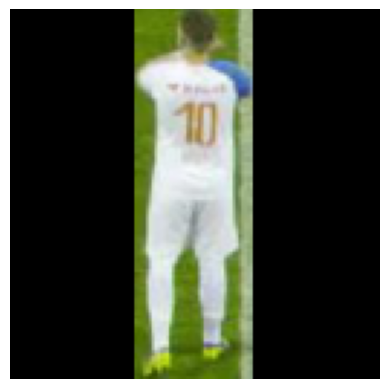

In [23]:
import matplotlib.pyplot as plt

# Convert the transformed tensor back to an image for visualization
transformed_image_np = transformed_image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize
plt.imshow(transformed_image_np)
plt.axis('off')
plt.show()

### Define Dataset and Collate function for batching variable length sequences

In [ ]:
class TrackletDataset(Dataset):

    def __init__(self, img_dir, gt_file):
        self.tracklets, self.labels = self.load_tracklets(img_dir, gt_file)

    def load_tracklets(self, img_dir, gt_file):
        with open(gt_file, "r") as f:
            gt_data = json.load(f)
        tracklets = []
        labels = []

        self.transform = transforms.Compose([
            ResizeAndPadTransform(target_height=128, target_width=128)
        ])

        # Each subdirectory is a tracklet (e.g., "0", "1", "2", etc.)
        for tracklet_id in tqdm(os.listdir(img_dir), desc="Loading tracklets"):
            tracklet_path = os.path.join(img_dir, tracklet_id)
            if os.path.isdir(tracklet_path):
                if tracklet_id not in gt_data:
                    print(f"Tracklet {tracklet_id} not found in GT file. Skipping.")
                    continue
                label = gt_data[tracklet_id]
                images = []
                # Sort images by filename to maintain order
                for filename in sorted(os.listdir(tracklet_path)):
                    if filename.endswith(".jpg"):
                        img_path = os.path.join(tracklet_path, filename)
                        try:
                            img = Image.open(img_path).convert("RGB")
                            img_tensor = self.transform(img)
                            images.append(img_tensor)
                        except Exception as e:
                            print(f"Error loading image {img_path}: {e}")
                            continue
                if len(images) == 0:
                    continue
                try:
                    tracklets.append(torch.stack(images))       # Each tracklet is shaped: (sequence_length, C, H, W)
                except Exception as e:
                    print(f"{tracklet_id}: {e}")
                labels.append(0 if label == -1 else label)  # we use 0 to denote the illegible class since nn.CrossEntropyLoss() requires labels starting at 0
                    
        print(f"Loaded {len(tracklets)} tracklets.")
        return tracklets, labels

    def __len__(self):
        return len(self.tracklets)

    def __getitem__(self, idx):
        return self.tracklets[idx], self.labels[idx]

def collate_fn(batch):
    """
    Since some tracklets are longer than others, we need a custom collate function to divide them into batches.
    Our approach pads each sequence to the length of the longest sequence so it may be passed to nn.utils.rnn.pack_padded_sequence().
    Each element in the batch is a tuple (tracklet_tensor, label), where each tracklet_tensor has shape (max_seq_len, C, H, W).
    """
    tracklets, labels = zip(*batch)
    seq_lengths = [t.shape[0] for t in tracklets]

    # Sort the batch in descending order of sequence lengths
    sorted_indices = sorted(range(len(seq_lengths)), key=lambda i: seq_lengths[i], reverse=True)
    sorted_tracklets = [tracklets[i] for i in sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_seq_lengths = [seq_lengths[i] for i in sorted_indices]

    # Pad the tracklet sequences to the maximum sequence length in the batch
    padded_tracklets = pad_sequence(sorted_tracklets, batch_first=True)

    return padded_tracklets, torch.tensor(sorted_seq_lengths), torch.tensor(sorted_labels)

### Define the backbone architecture (taken from Laura's code)

In [25]:
class JerseyNumberClassifier(nn.Module):
    def __init__(self):
        super(JerseyNumberClassifier, self).__init__()
        
        # 128x128 input
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 64x64 input
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 32x32 input
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 16x16 input
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 8x8 input
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 4x4 input
        self.block6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 2x2 output instead of 1x1
        self.fc = nn.Sequential(
            nn.Linear(1024 * 2 * 2, 8192),  # Adjusted from 1024 * 1 * 1
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 100)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = torch.flatten(x, start_dim=1) 
        x = self.fc(x)
        return x

In [26]:
cnn_model = torch.load("test_cnn.pth", weights_only=False)

# Checking whether .pth file contains model as well
if isinstance(cnn_model, dict):  # if only state_dict, then it means weights only
    print("Contains only weights.")
elif isinstance(cnn_model, nn.Module):  # entire model
    print("Contains the full cnn_model.")
else:
    print("Unknown format.")

Contains the full cnn_model.


In [27]:
class CNNFeatureExtractor(nn.Module):
    """Wrapper around the full model without the fc block."""
    def __init__(self, full_model):
        super(CNNFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            full_model.block1,
            full_model.block2,
            full_model.block3,
            full_model.block4,
            full_model.block5,
            full_model.block6       # Should be 1024 channels with 2x2 activation maps
        )

    def forward(self, x):
        x = self.features(x)
        return x

In [28]:
class ImageRNN(nn.Module):
    def __init__(self, cnn_model, hidden_dim=512, num_layers=2, rnn_output_dim=100, rnn_type="LSTM", cnn_feature_dim=256):
        super(ImageRNN, self).__init__()
        # CNN feature extractor without the fc block
        self.cnn = CNNFeatureExtractor(cnn_model)
        # CNN output dimension is 1024 * 2 * 2 = 4096
        self.cnn_out_dim = 1024 * 2 * 2  
        # Projection layer: from 4096 to desired cnn_feature_dim
        self.cnn_project = nn.Linear(self.cnn_out_dim, cnn_feature_dim)
        # RNN layer: input dimension is cnn_feature_dim
        rnn_cls = nn.LSTM if rnn_type == 'LSTM' else nn.GRU
        self.rnn = rnn_cls(input_size=cnn_feature_dim, hidden_size=hidden_dim, 
                           num_layers=num_layers, batch_first=True)
        # Final output layer
        self.fc = nn.Linear(hidden_dim, rnn_output_dim)

    def forward(self, x, seq_lengths):
        """
        x: Tensor of shape (batch_size, seq_len, C, H, W)
        seq_lengths: Tensor or list of actual sequence lengths for each tracklet.
        """
        batch_size, seq_len, C, H, W = x.shape
        cnn_features = []
        # Process each frame in the sequence
        for i in range(seq_len):
            img_batch = x[:, i]  # Shape: (batch_size, C, H, W)
            with torch.no_grad():  # Freeze CNN feature extractor if desired
                features = self.cnn(img_batch)  # Shape: (batch_size, 1024, 2, 2)
            features = features.view(batch_size, -1)  # Flatten to (batch_size, 4096)
            features = self.cnn_project(features)       # Project to (batch_size, cnn_feature_dim)
            cnn_features.append(features)
        # Stack along the time dimension: (batch_size, seq_len, cnn_feature_dim)
        cnn_features = torch.stack(cnn_features, dim=1)
        # Pack the padded sequence
        packed_seq = pack_padded_sequence(cnn_features, lengths=seq_lengths, batch_first=True, enforce_sorted=True)
        packed_out, _ = self.rnn(packed_seq)
        # Unpack the sequence
        padded_out, _ = pad_packed_sequence(packed_out, batch_first=True)
        # For each sample, select the output at the last valid time step
        last_outputs = []
        for i, length in enumerate(seq_lengths):
            last_outputs.append(padded_out[i, length - 1, :])
        last_outputs = torch.stack(last_outputs, dim=0)
        output = self.fc(last_outputs)  # Final prediction: (batch_size, rnn_output_dim)
        return output

In [29]:
IMG_DIR = r"C:/Users/syeda/OneDrive/Desktop/4th Year/COSC419/jersey-number-pipeline/data/SoccerNet/train/images"
GT_FILE = r"C:/Users/syeda/OneDrive/Desktop/4th Year/COSC419/jersey-number-pipeline/data/SoccerNet/train/train_gt.json"

BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
dataset = TrackletDataset(os.path.join(IMG_DIR), os.path.join(GT_FILE))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

: 

In [ ]:
data = {"tracklets": dataset.tracklets, "labels": torch.tensor(dataset.labels)}
    
torch.save(data, "./preprocessed_tracklets.pt")

In [ ]:
cnn_model.eval() # freeze CNN weights 

model = ImageRNN(cnn_model=cnn_model, hidden_dim=512, num_layers=2, rnn_output_dim=1, cnn_feature_dim=512)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()  # or another appropriate loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)